In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")

# print("Path to dataset files:", path)

In [3]:
CSV_PATH = "/Users/igor/Documents/GitHub/Camp2025/lesson24/data/MNIST/raw/A_Z Handwritten Data.csv" 
batch_size = 256
epochs = 10
lr = 1e-3
val_ratio = 0.1
test_ratio = 0.1
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
print("Loading CSV...")
df = pd.read_csv(CSV_PATH, header=None)
labels = df.iloc[:, 0].values.astype(np.int64)
pixels = df.iloc[:, 1:].values.astype(np.float32)

Loading CSV...


In [6]:
img_flat = pixels.shape[1]
side = int(math.sqrt(img_flat))
assert side * side == img_flat, f"Expected square images, got {img_flat} pixels"
assert side <= 80, "Image side exceeds 80, but requirement is <=80x80."

In [7]:
pixels /= 255.0

N = len(labels)
indices = np.arange(N)
np.random.shuffle(indices)

test_size = int(N * test_ratio)
val_size = int(N * val_ratio)
train_size = N - val_size - test_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, y_train = pixels[train_idx], labels[train_idx]
X_val,   y_val   = pixels[val_idx],   labels[val_idx]
X_test,  y_test  = pixels[test_idx],  labels[test_idx]

In [8]:
class AZDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)          
        self.y = torch.from_numpy(y)       

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img_flat = self.X[idx]
        img_2d = img_flat.view(1, side, side)
        label = self.y[idx]
        return img_flat, img_2d, label

train_ds = AZDataset(X_train, y_train)
val_ds   = AZDataset(X_val, y_val)
test_ds  = AZDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes=26):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x_flat):
        return self.net(x_flat)

model = MLP(input_dim=img_flat, num_classes=26).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x_flat, _, y in loader:
            x_flat = x_flat.to(device)
            y = y.to(device)
            logits = model(x_flat)
            loss = criterion(logits, y)
            total_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return total_loss / total, correct / total

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Training...")
for epoch in range(1, epochs+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x_flat, _, y in train_loader:
        x_flat = x_flat.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x_flat)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
          f"train_acc={train_acc*100:.2f}% val_acc={val_acc*100:.2f}%")


Training...
Epoch 01/10 | train_loss=0.3821 val_loss=0.1371 train_acc=89.11% val_acc=96.14%
Epoch 02/10 | train_loss=0.1358 val_loss=0.0997 train_acc=96.06% val_acc=97.09%
Epoch 03/10 | train_loss=0.1037 val_loss=0.0783 train_acc=96.90% val_acc=97.77%
Epoch 04/10 | train_loss=0.0852 val_loss=0.0686 train_acc=97.45% val_acc=98.06%
Epoch 05/10 | train_loss=0.0751 val_loss=0.0609 train_acc=97.72% val_acc=98.26%
Epoch 06/10 | train_loss=0.0655 val_loss=0.0623 train_acc=97.98% val_acc=98.24%
Epoch 07/10 | train_loss=0.0605 val_loss=0.0531 train_acc=98.09% val_acc=98.47%
Epoch 08/10 | train_loss=0.0547 val_loss=0.0533 train_acc=98.29% val_acc=98.49%
Epoch 09/10 | train_loss=0.0516 val_loss=0.0547 train_acc=98.37% val_acc=98.48%
Epoch 10/10 | train_loss=0.0475 val_loss=0.0487 train_acc=98.50% val_acc=98.65%


In [11]:
test_loss, test_acc = evaluate(test_loader)
print(f"\nTest: loss={test_loss:.4f} acc={test_acc*100:.2f}%")


Test: loss=0.0462 acc=98.69%


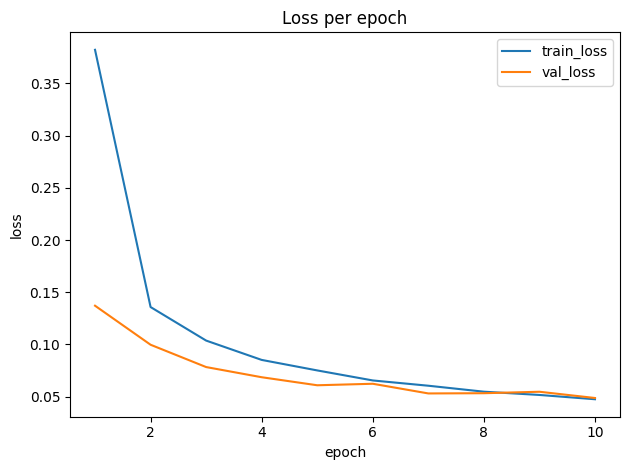

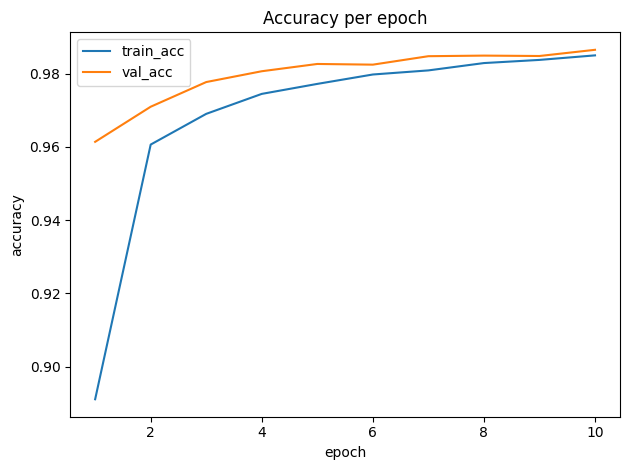

In [12]:
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="train_loss")
plt.plot(range(1, epochs+1), val_losses, label="val_loss")
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), train_accs, label="train_acc")
plt.plot(range(1, epochs+1), val_accs, label="val_acc")
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()
plt.show()

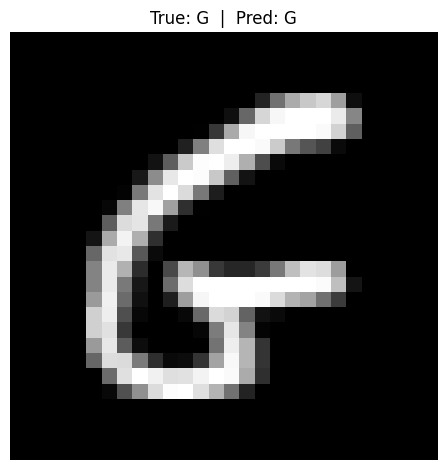

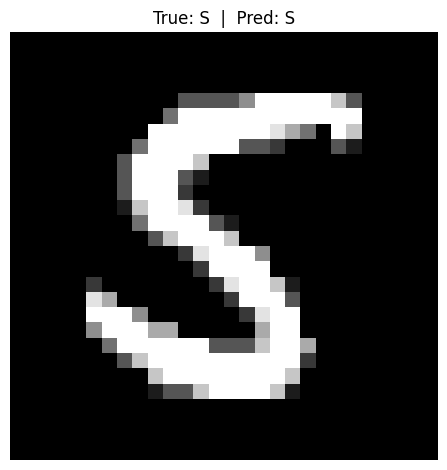

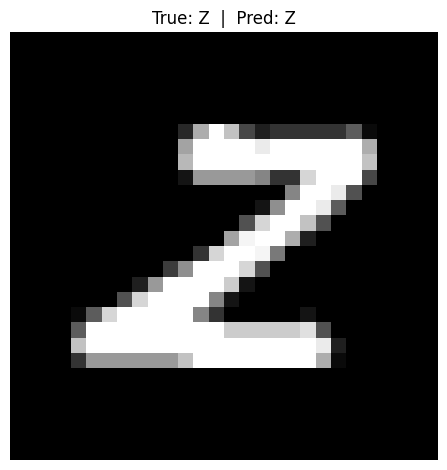

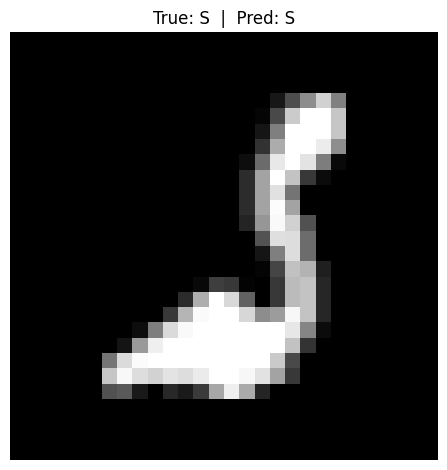

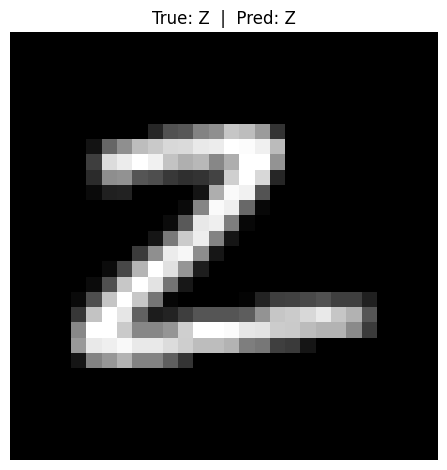

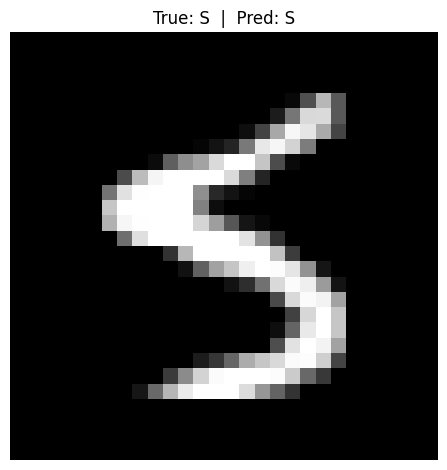

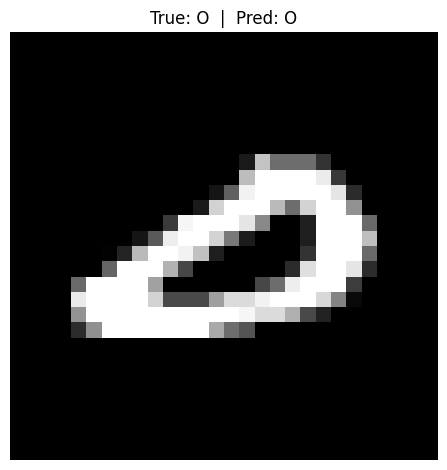

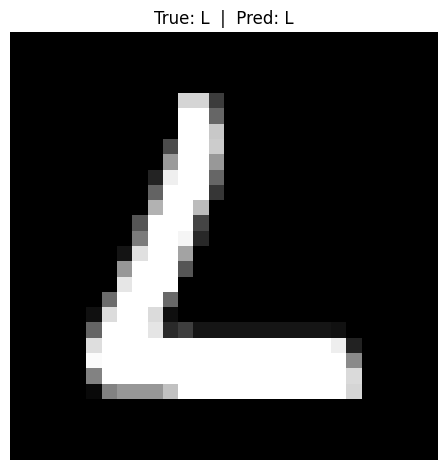

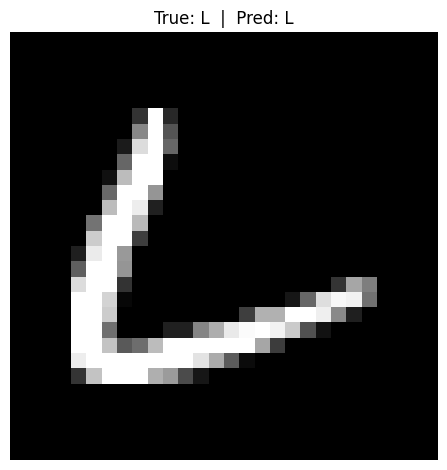

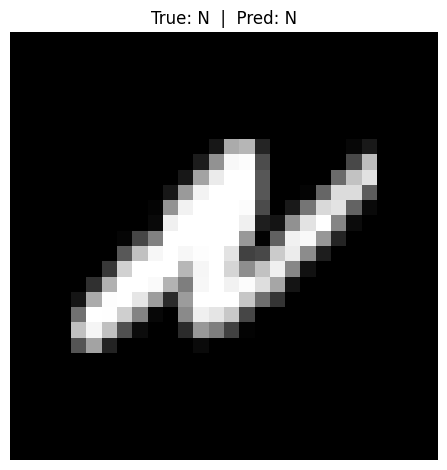

Plotted 10 test samples.


In [13]:
idxs = np.random.choice(len(test_ds), size=10, replace=False)
letters = [chr(ord('A') + i) for i in range(26)]

model.eval()
fig_count = 0
for i, idx in enumerate(idxs, start=1):
    x_flat, x_img, y_true = test_ds[idx]
    with torch.no_grad():
        logits = model(x_flat.to(device).unsqueeze(0))
        pred = logits.argmax(dim=1).item()

    plt.figure()
    plt.imshow(x_img.squeeze(0).numpy(), cmap="gray")
    plt.title(f"True: {letters[y_true.item()]}  |  Pred: {letters[pred]}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    fig_count += 1

print(f"Plotted {fig_count} test samples.")